# Install Necessary Packages

In [ ]:
!pip install wfdb
!pip install keras-tuner
!pip install tensorflow-addons


# Receive All 100Hz Dataset Files

## Download Files

In [ ]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')

# Get the file from your Google Drive using the full path
!cp /content/drive/MyDrive/dataset/ptbxl_filtered_100hz.zip /content
!cp /content/drive/MyDrive/dataset/ptb_filtered_splitted_100hz.zip /content
!cp /content/drive/MyDrive/dataset/incart_splitted_filtered_100hz.zip /content

# Unzip the file
!unzip ptbxl_filtered_100hz.zip
!unzip ptb_filtered_splitted_100hz.zip
!unzip incart_splitted_filtered_100hz.zip

## Create Combined Dataset Folder and Move Files

In [ ]:
import os
import shutil

# Define the combined dataset folder
combined_dataset_folder = "/content/combined_dataset_100hz"
# Remove existing folder if it exists, then recreate it
if os.path.exists(combined_dataset_folder):
    shutil.rmtree(combined_dataset_folder)
os.makedirs(combined_dataset_folder, exist_ok=True)

# Define class folders that will be in the combined dataset
class_folders = ['NORM', 'MI', 'HYP']
# Create the class subfolders inside the combined dataset folder
for class_folder in class_folders:
    os.mkdir(os.path.join(combined_dataset_folder, class_folder))

# Define source folders and their respective subfolders
source_folders = {
    "/content/filtered_100hz": ["MI", "HYP", "NORM"],
    "/content/ptb_filtered_splitted_100hz": ["MI", "HYP", "NORM"],
    "/content/incart_splitted_filtered_100hz": ["MI", "HYP"]
}

# Copy each file from the source subfolders to the combined dataset subfolders
for source_folder, sub_folders in source_folders.items():

    for sub_folder in sub_folders:
        source_sub_folder = os.path.join(source_folder, sub_folder)
        target_folder = os.path.join(combined_dataset_folder, sub_folder)
        count = 0
        # Ensure that the source subfolder exists before processing
        if os.path.exists(source_sub_folder):
            for file in os.listdir(source_sub_folder):
                count= count +1
                file_path = os.path.join(source_sub_folder, file)
                target_path = os.path.join(target_folder, file)

                # Copy the file to the target folder
                shutil.copyfile(file_path, target_path)
            print(count)

In [ ]:
import os

combined_dataset_folder = "/content/combined_dataset_100hz"
class_folders = ['NORM', 'MI', 'HYP']

for class_folder in class_folders:
  class_folder_path = os.path.join(combined_dataset_folder, class_folder)
  num_files = len([f for f in os.listdir(class_folder_path) if f.endswith('.hea')])
  print(f"{class_folder}: {num_files}")


# Window Signal Model

## Create Training Dataset

In [ ]:
import wfdb
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import numpy as np

# Configuration
sampling_rate = 100
data_dir = '/content/combined_dataset_100hz/'
signal_length = 1000
class_names = ['NORM', 'MI', 'HYP']
num_channels = 12
batch_size = 8
validation_split = 0.2
test_split = 0.1
window_size = 150
stride = window_size//2
max_windows = (signal_length - window_size) // stride + 1

# Prepare a list of all files and their labels
file_label_pairs = []
labels = []
for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for file in os.listdir(class_dir):
        if file.endswith('.hea'):
            file_path = os.path.join(class_dir, file[:-4])
            file_label_pairs.append((file_path, class_idx))
            labels.append(class_idx)

# Split data into training, validation, and test sets using stratified splitting
train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
    file_label_pairs, labels, test_size=validation_split + test_split, stratify=labels)

val_pairs, test_pairs, val_labels, test_labels = train_test_split(
    temp_pairs, temp_labels, test_size=test_split / (validation_split + test_split), stratify=temp_labels)

def signal_generator(pairs):
    for file_path, class_idx in pairs:
        record = wfdb.rdrecord(file_path)
        signal = record.p_signal
        ann = wfdb.rdann(file_path, 'atr')
        r_peaks = ann.sample
        num_windows = (signal_length - window_size) // stride + 1
        windows = []
        r_peak_windows = []

        for i in range(num_windows):
            start = i * stride
            end = start + window_size
            window = signal[start:end].copy()
            windows.append(window)

            window_r_peaks = np.zeros(window_size)
            r_peak_positions = r_peaks[(r_peaks >= start) & (r_peaks < end)] - start
            window_r_peaks[r_peak_positions] = 1
            r_peak_windows.append(np.tile(window_r_peaks, (num_channels, 1)).T)

        arr_windows = np.array(windows)
        arr_r_peak_windows = np.array(r_peak_windows)

        yield (arr_windows, arr_r_peak_windows), class_idx

# Create generators for training, validation, and test datasets
train_signal_generator = lambda: signal_generator(train_pairs)
val_signal_generator = lambda: signal_generator(val_pairs)
test_signal_generator = lambda: signal_generator(test_pairs)

# Preprocessing function
def preprocess(data, label):
    windows, r_peak_windows = data
    windows = tf.cast(windows, tf.float32)
    r_peak_windows = tf.cast(r_peak_windows, tf.float32)
    label = tf.cast(label, tf.int32)  # Ensure labels are integers
    return (windows, r_peak_windows), label

output_signature = (
    (tf.TensorSpec(shape=(max_windows, window_size, num_channels), dtype=tf.float32),
    tf.TensorSpec(shape=(max_windows, window_size, num_channels), dtype=tf.float32)),
    tf.TensorSpec(shape=(), dtype=tf.int32)  # Ensure label shape is correct
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(train_signal_generator, output_signature=output_signature)
train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(val_signal_generator, output_signature=output_signature)
val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(test_signal_generator, output_signature=output_signature)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Check the element specification of the train dataset
train_dataset.element_spec


In [ ]:
import wfdb
import os
from sklearn.model_selection import train_test_split
import numpy as np

# Function to count samples in each class
def count_classes(pairs, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for pair in pairs:
        class_counts[class_names[pair[1]]] += 1
    return class_counts

# Count samples in each class for training, validation, and test sets
train_counts = count_classes(train_pairs, class_names)
val_counts = count_classes(val_pairs, class_names)
test_counts = count_classes(test_pairs, class_names)

# Print the counts
print("Training set class distribution:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}")

print("\nValidation set class distribution:")
for class_name, count in val_counts.items():
    print(f"{class_name}: {count}")

print("\nTest set class distribution:")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_between_durations(signal, target_fs=sampling_rate, start_duration=0, end_duration=10):
    """
    Plot a portion of a signal within specified durations.

    Parameters:
        signal (ndarray): The signal to plot.
        target_fs (float): Target sampling frequency (Hz).
        start_duration (float): Start duration in seconds.
        end_duration (float): End duration in seconds.
    """
    # Calculate start and end indices based on durations and target sampling frequency
    start_index = int(start_duration * target_fs)
    end_index = int(end_duration * target_fs)

    # Ensure indices are within the range of the signal array
    start_index = max(0, start_index)
    end_index = min(len(signal), end_index)

    # Create time array based on signal length and sampling frequency
    time = np.arange(len(signal)) / target_fs

    # Plot the desired signal
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(time[start_index:end_index], signal[start_index:end_index])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')
    ax.set_title(f'Signal (Duration: {start_duration} - {end_duration} s)')
    ax.grid(True)
    ax.set_aspect(aspect='auto')  # Ensures vertical size remains fixed
    plt.show()


Windows shape: (12, 150, 12), R-peak indices shape: (12, 150, 12), Label: 1


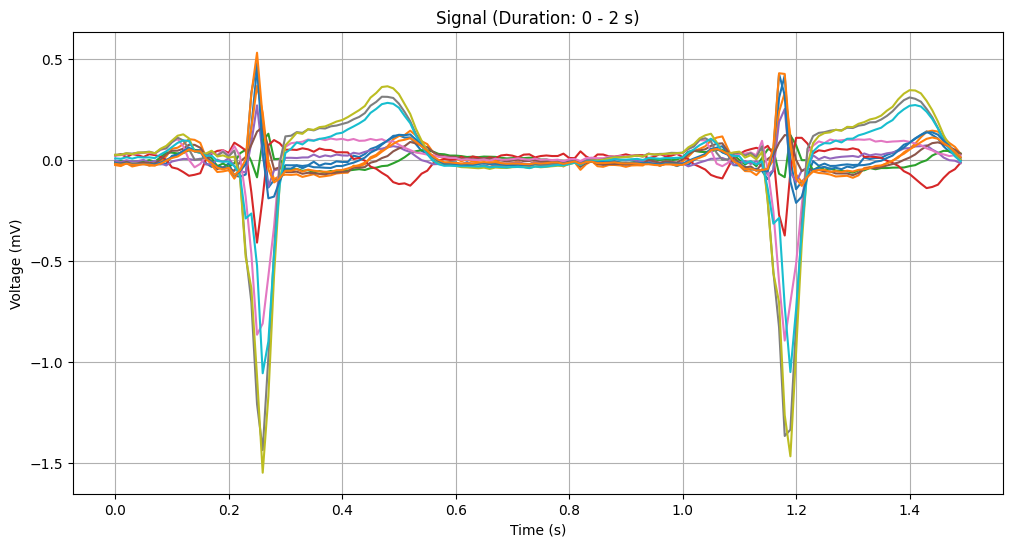

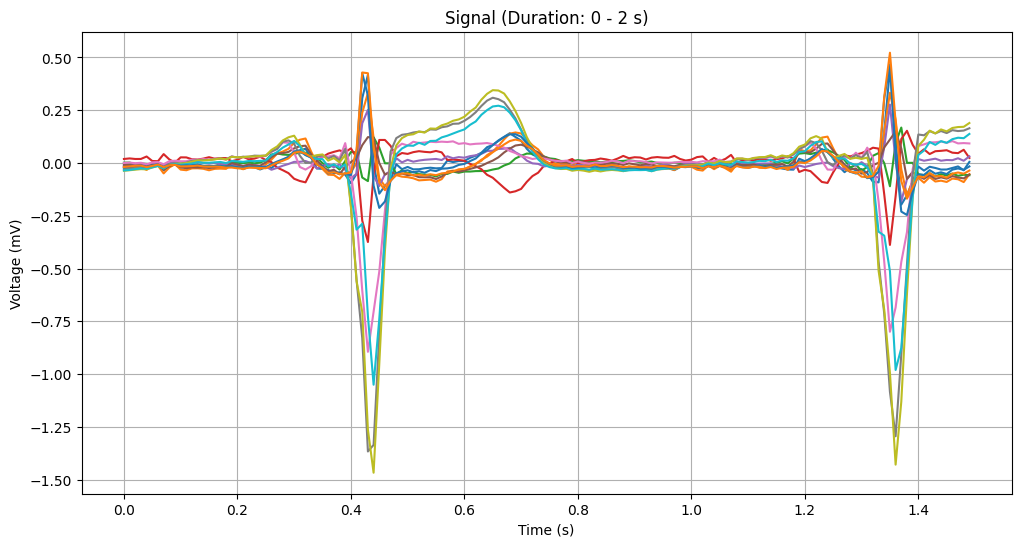

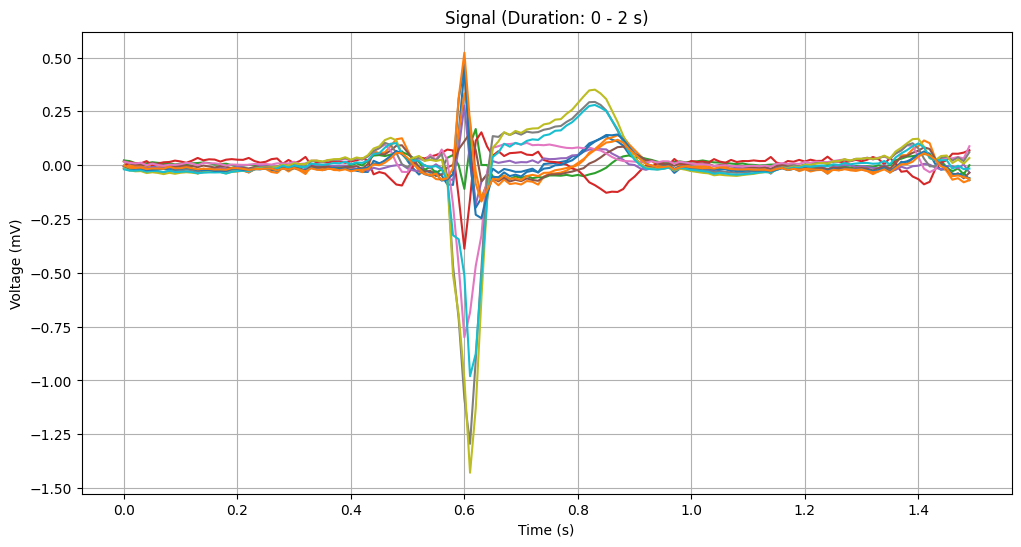

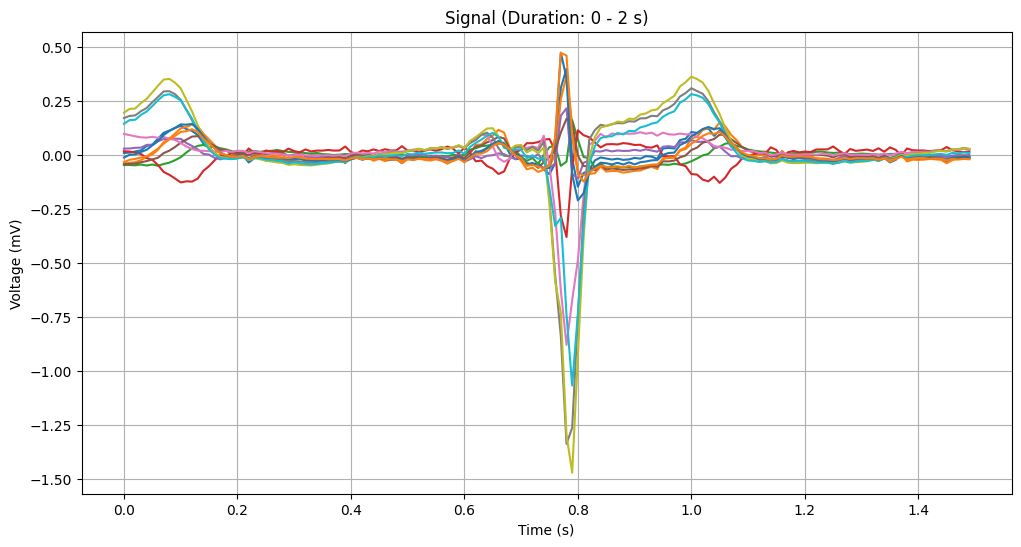

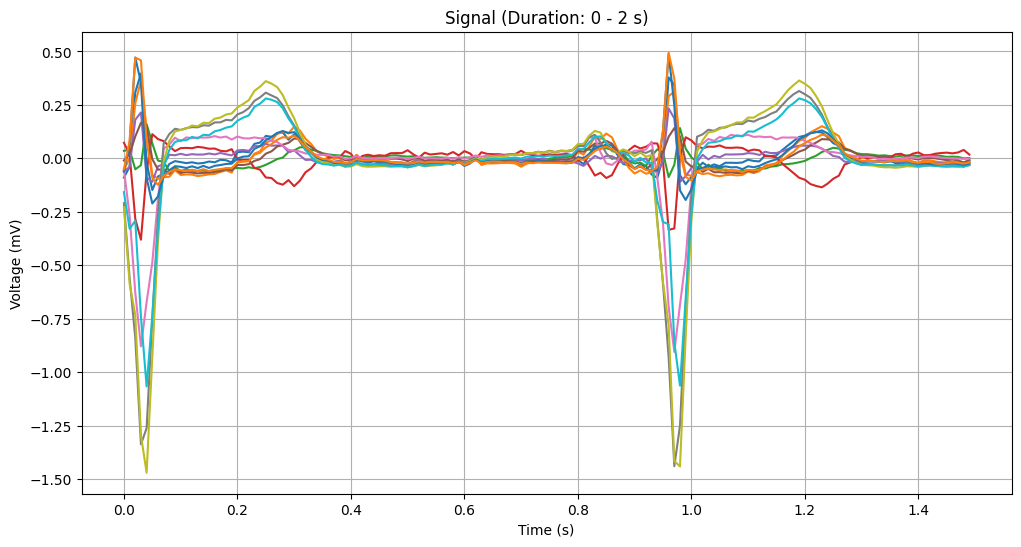

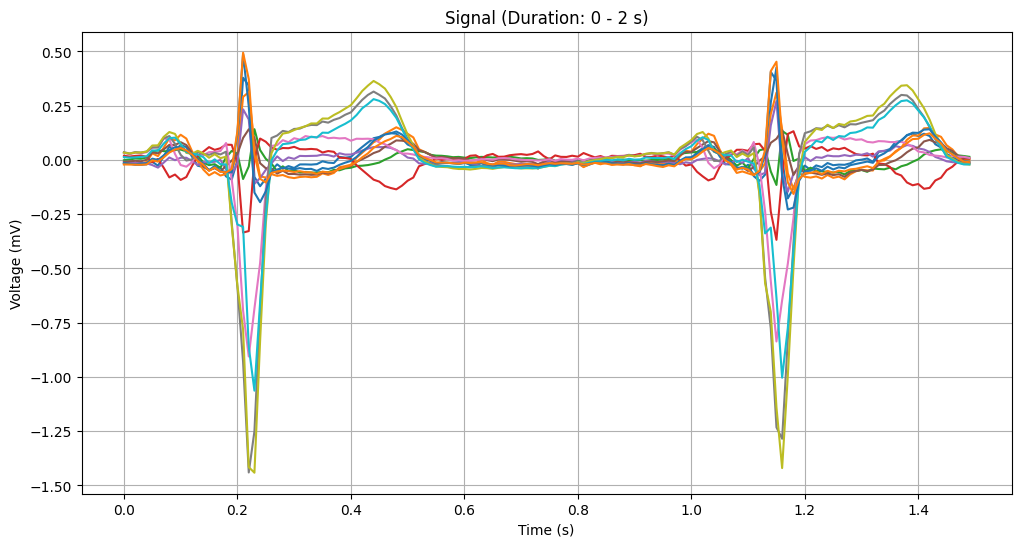

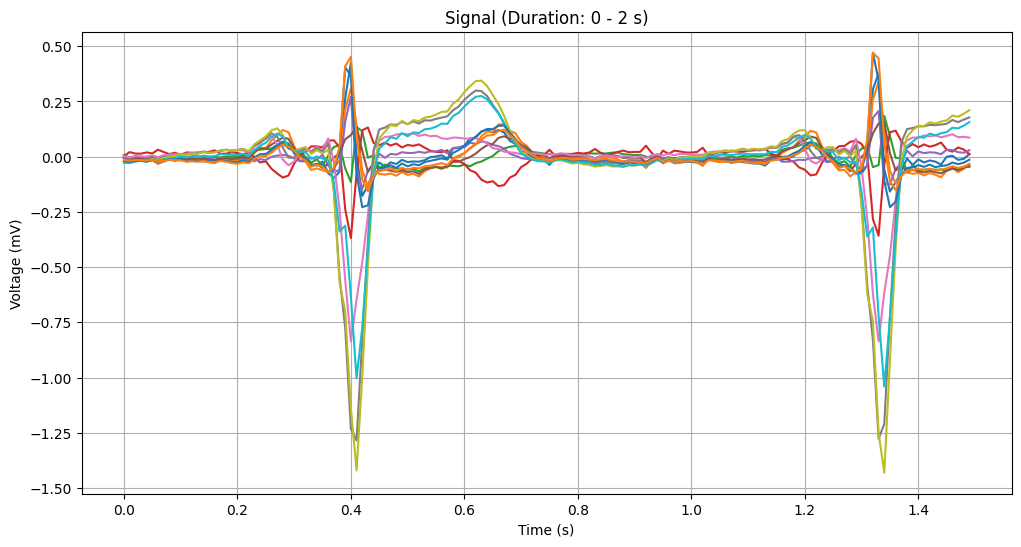

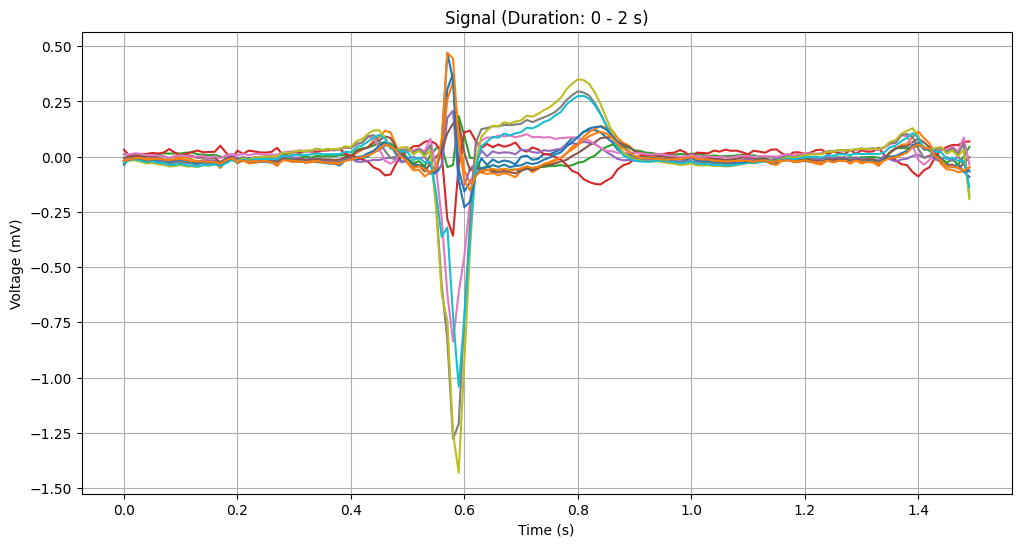

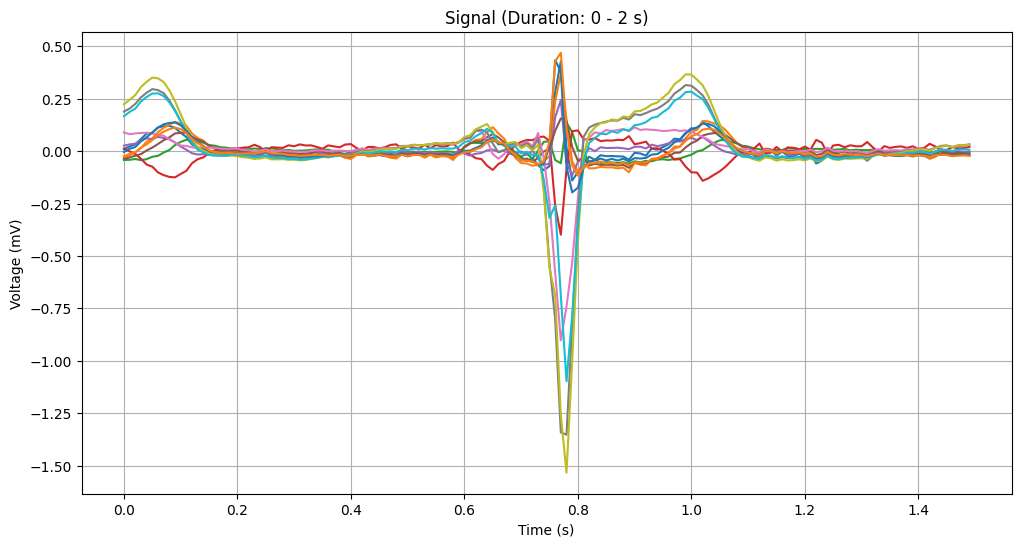

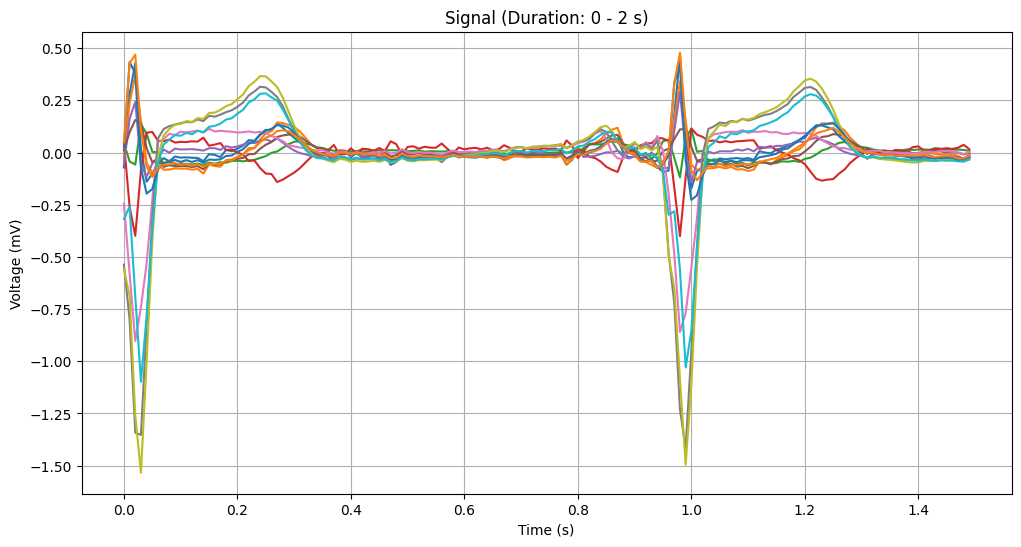

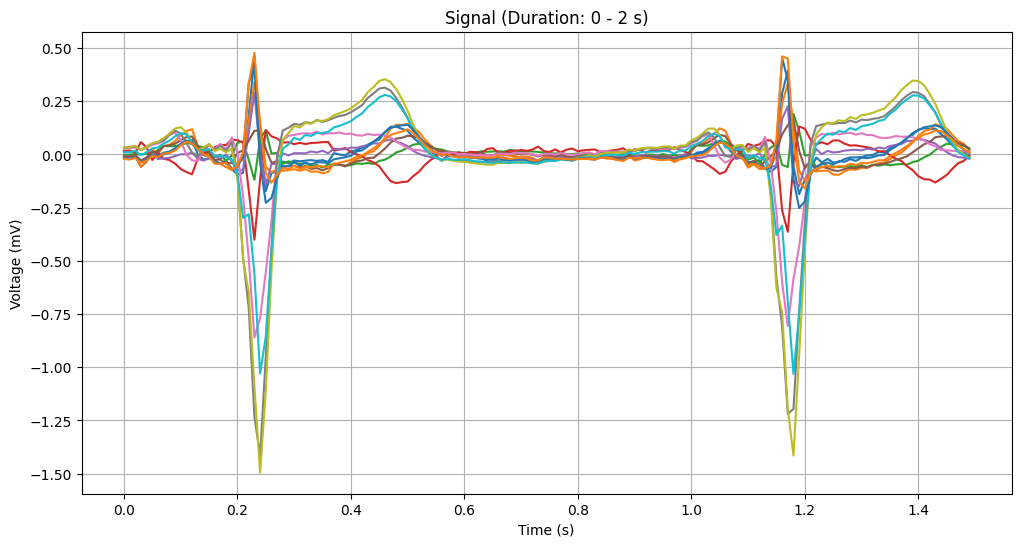

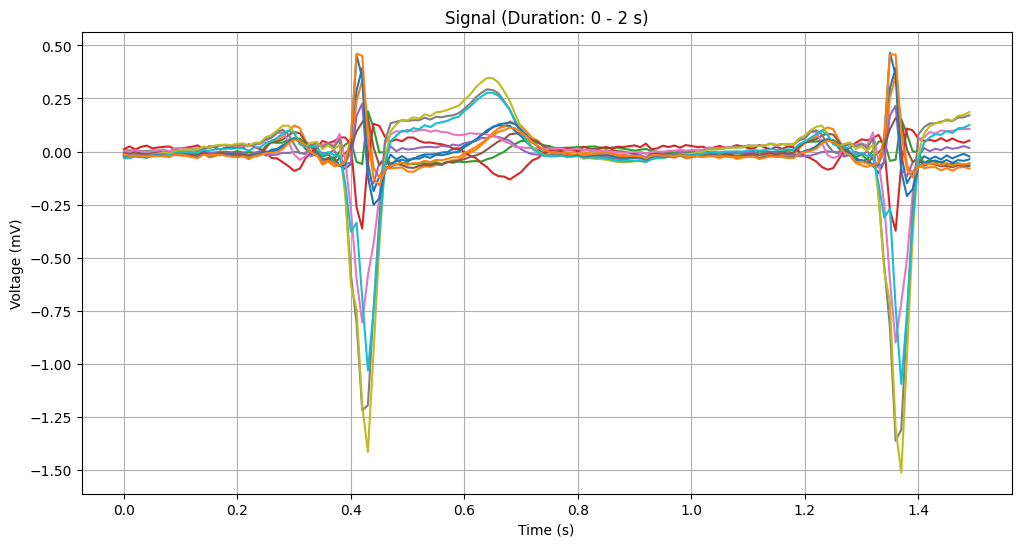

In [ ]:
# Take 5 signal batch from train dataset, print shape.
for (windows, rpeaks), label in test_dataset.take(5):
    print(f"Windows shape: {windows[0].shape}, R-peak indices shape: {rpeaks[0].shape}, Label: {label[0].numpy()}")

    for i in range(windows[0].shape[0]):
      plot_signals_between_durations(windows[0][i], start_duration=0, end_duration=2)
    break

## Create Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D, MultiHeadAttention, Input, Lambda, TimeDistributed, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

class EnhancedPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, r_peak_factor=5):
        super(EnhancedPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.r_peak_factor = r_peak_factor

    def get_angles(self, pos, i, d_model):
        angles = pos / tf.math.pow(10000.0, (2 * (tf.cast(i, tf.float32) // 2)) / tf.cast(d_model, tf.float32))
        return angles

    def call(self, inputs, r_peaks):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        feature_dim = tf.shape(inputs)[2]

        angle_rads = self.get_angles(
            tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32),
            tf.range(feature_dim)[tf.newaxis, :],
            feature_dim
        )

        angle_rads = tf.where(tf.range(feature_dim) % 2 == 0,
                              tf.math.sin(angle_rads),
                              tf.math.cos(angle_rads))
        pos_encoding = angle_rads[tf.newaxis, :, :]
        pos_encoding = tf.tile(pos_encoding, [batch_size, 1, 1])

        r_peaks_amplified = r_peaks * self.r_peak_factor

        return inputs + tf.cast(pos_encoding, tf.float32) + r_peaks_amplified

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "r_peak_factor": self.r_peak_factor
        })
        return config

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, activation=tf.keras.activations.relu):
    attention_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + inputs)

    ffn_output = Dense(ff_dim, activation=activation, kernel_regularizer=l2(0.001))(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)

    return LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

def build_transformer_sequence_model(window_size, num_channels, max_windows, class_names, d_model=12, num_heads=4, ff_dim=256, num_transformer_blocks=3, dropout_rate=0.2, activation="leaky_relu", kernel_regularizer=l2(0.01)):
    input_windows = Input(shape=(max_windows, window_size, num_channels))
    input_rpeak_windows = Input(shape=(max_windows, window_size, num_channels))

    print(f"input_windows shape: {input_windows.shape}")
    print(f"input_rpeak_windows shape: {input_rpeak_windows.shape}")

    # Embedding for each window
    cnn_out = TimeDistributed(Conv1D(filters=d_model, kernel_size=3, padding="same", activation=activation))(input_windows)
    cnn_out = TimeDistributed(Dropout(dropout_rate))(cnn_out)

    def apply_pos_encoding(inputs):
        window, rpeak = inputs
        pos_encoding = EnhancedPositionalEncoding(d_model)
        return pos_encoding(window, rpeak)

    # Applying positional encoding to each window
    encoded_windows = TimeDistributed(Lambda(lambda x: apply_pos_encoding(x)))([cnn_out, input_rpeak_windows])

    x = encoded_windows
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, d_model, num_heads, ff_dim, dropout_rate, activation)

    # Get average of each channel
    x = TimeDistributed(GlobalAveragePooling1D())(x)

    # Flatten the output
    x = Flatten()(x)

    # Dense layers for final classification
    x = Dense(108, activation=activation)(x)
    x = Dropout(dropout_rate)(x)

    output = Dense(len(class_names), activation="softmax")(x)
    model = Model(inputs=[input_windows, input_rpeak_windows], outputs=output)

    return model

model = build_transformer_sequence_model(window_size=window_size, num_channels=num_channels, max_windows=max_windows, class_names=class_names)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()


input_windows shape: (None, 12, 150, 12)
input_rpeak_windows shape: (None, 12, 150, 12)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 12, 150, 12)]        0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 12, 150, 12)          444       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 12, 150, 12)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
      

## Train Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras', monitor='val_loss', save_best_only=True, verbose=1),
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
  )

# Save the model
model.save('model.keras')

from google.colab import files
files.download('model.keras')

# Evaluate the model to obtain loss and accuracy on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Function to retrieve the true labels from the dataset
def get_true_labels(dataset):
    all_labels = []
    for _, y in dataset:
        all_labels.extend(y.numpy())
    return np.array(all_labels)

# Obtain predictions from the model
y_pred_probs = model.predict(test_dataset)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# Retrieve true labels
y_true = get_true_labels(test_dataset)

# Generate a classification report (Precision, Recall, F1 Score)
class_names = ['NORM', 'MI', 'HYP']
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\nClassification Report:")
print(class_report)

# Calculate mean F1 score, precision, and recall
mean_f1_score = f1_score(y_true, y_pred, average='macro')
mean_precision = precision_score(y_true, y_pred, average='macro')
mean_recall = recall_score(y_true, y_pred, average='macro')

print(f"Mean F1 Score: {mean_f1_score:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
